In [3]:
%load_ext autoreload
%autoreload 2


import modish
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure3_modalities_functional'

import flotilla

study = flotilla.embark('singlecell_pnm_figure2_modalities')
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))


2015-09-30 10:17:58	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities/datapackage.json
2015-09-30 10:17:58	Parsing datapackage to create a Study object
2015-09-30 10:19:08	Initializing Study
2015-09-30 10:19:08	Initializing Predictor configuration manager for Study
2015-09-30 10:19:08	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-09-30 10:19:08	Added ExtraTreesClassifier to default predictors
2015-09-30 10:19:08	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-09-30 10:19:08	Added ExtraTreesRegressor to default predictors
2015-09-30 10:19:08	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-09-30 10:19:08	Added GradientBoostingClassifier to default predictors
2015-09-30 10:19:08	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boost

## Overlap of modalities between celltypes

Get events that have a modality estimated in all celltypes (aka 20+ cell observations per celltype)

In [21]:
modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_name').filter(
    lambda x: len(x) == len(study.phenotype_order))

### Venn Diagrams

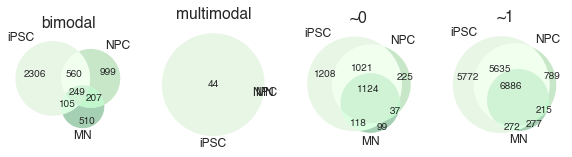

In [22]:
import matplotlib_venn

n_modalities = len(modalities_all_celltypes.groupby('modality').size())
width, height = 2.5, 2.5

fig, axes = plt.subplots(figsize=(width*n_modalities, height), ncols=n_modalities)

for ax, (modality, df) in zip(axes, study.supplemental.modalities_tidy.groupby('modality')):
#     fig, ax = plt.subplots(figsize=(2.5, 2.5))
    grouped = df.groupby('phenotype')
    events = [set(grouped.get_group(p).event_name) if p in grouped.groups else set([]) for p in study.phenotype_order]
    labels = study.phenotype_order
    colors = [study.phenotype_to_color[x] for x in labels]
    matplotlib_venn.venn3(events, set_labels=labels, set_colors=colors, ax=ax)
    ax.set_title(modality)
fig.savefig('modalities_venn.pdf')
fig.savefig('modalities_venn.png', dpi=150)

### Heatmap of transitions from one celltype to the next

modality_transitions_iPSC_to_NPC_heatmap.pdf
modality_transitions_NPC_to_MN_heatmap.pdf
modality_transitions_iPSC_to_MN_heatmap.pdf


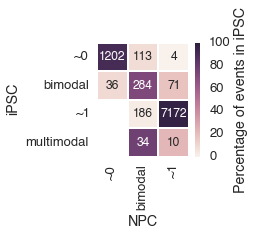

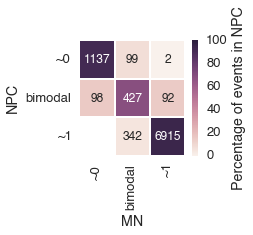

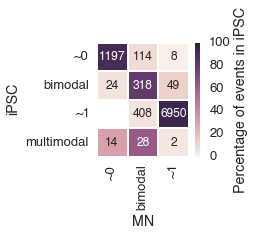

In [24]:
import collections
import matplotlib as mpl
from scipy.stats import fisher_exact
import colorsys
from modish import MODALITY_ORDER, MODALITY_TO_COLOR


modality_subset = ['~0', 'bimodal', '~1', 'multimodal']

grouped = modalities_all_celltypes.groupby('phenotype')

phenotype_transitions = study.phenotype_transitions + [('iPSC', 'MN')]

for phenotype1, phenotype2 in phenotype_transitions:
    modality_transitions = pd.DataFrame(0, index=MODALITY_ORDER, 
                                        columns=MODALITY_ORDER)
    modality_transitions.index.name = phenotype1
    modality_transitions.columns.name = phenotype2
    
    phenotypes = (phenotype1, phenotype2)
    
    df = pd.concat([grouped.get_group(phenotype1), grouped.get_group(phenotype2)])
    df = df.set_index('phenotype')
    df = df.dropna()
    df = df.groupby('event_name').filter(lambda x: len(x) == 2)
    
    for event_name, df2 in df.groupby('event_name'):
            modality1 = df2.ix[phenotype1].modality
            modality2 = df2.ix[phenotype2].modality
            modality_transitions.ix[modality1, modality2] += 1
    modality_sizes = modality_transitions.sum(axis=1)
    modality_transitions = modality_transitions.reindex(index=MODALITY_ORDER, columns=MODALITY_ORDER)
    percentages = 100*modality_transitions.divide(modality_sizes,axis=0)
    
    # Only use a few of the modalities we're interested in
    percentages = percentages.loc[modality_subset, modality_subset]
    modality_transitions = modality_transitions.loc[modality_subset, modality_subset]
    
    percentages = percentages.replace(0, np.nan).dropna(how='all', axis=1).dropna(how='all', axis=0).fillna(0)
    modality_transitions = modality_transitions.replace(0, np.nan).dropna(how='all', axis=1).dropna(how='all', axis=0).fillna(0)
    
    # Anything that's zero will be whited out
    mask = percentages == 0
    
    # Plot the figure
    fig, ax = plt.subplots(figsize=(3.5, 3))
    sns.heatmap(percentages, cbar_kws={'label': 'Percentage of events in {}'.format(phenotype1)}, annot=False,
                vmin=0, vmax=100, linewidth=1, ax=ax, mask=mask)
    for ytl in ax.get_yticklabels():
        ytl.set(rotation=0)
    for xtl in ax.get_xticklabels():
        xtl.set(rotation=90)
        
    # Modification of seaborn's heatmap annotator
    """Add textual labels with the value in each cell."""
    values = modality_transitions.ix[::-1].values
    mesh = ax.collections[0]
    xpos, ypos = np.meshgrid(ax.get_xticks(), ax.get_yticks())
    for x, y, val, color in zip(xpos.flat, ypos.flat,
                                values.flat, mesh.get_facecolors()):
        if val is not np.ma.masked:
            _, l, _ = colorsys.rgb_to_hls(*color[:3])
            text_color = ".15" if l > .5 else "w"
            val = ("{:g}").format(val)
            ax.text(x, y, val, color=text_color,
                    ha="center", va="center", fontsize=12)
    fig.tight_layout()
    pdf = 'modality_transitions_{}_to_{}_heatmap.pdf'.format(phenotype1, phenotype2)
    print pdf
    fig.savefig(pdf)
    fig.savefig(pdf.replace('.pdf', '.png'), dpi=150)

### Stacked violinplots of modaliteis

#### Get modality categories across celltypes

In [6]:
import collections


modalities_all_celltypes_index = modalities_all_celltypes.set_index('phenotype')

modality_across_celltypes = modalities_all_celltypes_index.groupby('event_name', as_index=True, group_keys=False).apply(
    lambda x: ','.join(x.modality[study.phenotype_order]))
modality_across_celltypes.head()

event_name
exon:chr10:102114184-102114389:+@exon:chr10:102116289-102116521:+@exon:chr10:102120491-102124591:+         ~1,~1,~1
exon:chr10:102286732-102286831:-@exon:chr10:102286156-102286311:-@exon:chr10:102283497-102283686:-         ~1,~1,~1
exon:chr10:102286732-102286831:-@exon:chr10:102286156-102286311:-@exon:chr10:102283500-102283686:-         ~1,~1,~1
exon:chr10:103348089-103348157:+@exon:chr10:103354415-103354495:+@exon:chr10:103360495-103360619:+         ~1,~1,~1
exon:chr10:103360960-103361093:+@exon:chr10:103364897-103364969:+@exon:chr10:103368592-103368694:+    ~0,bimodal,~0
dtype: object

In [7]:
singles_no_outliers_ids = study.splicing.singles.index.difference(study.splicing.outliers.index)

In [8]:
modality_across_celltypes = modality_across_celltypes.str.strip(',')

### Make stacked violinplots of modalities

bimodal,bimodal,bimodal (249,)
bimodal,bimodal,~0 (11,)
bimodal,bimodal,~1 (24,)
bimodal,~0,bimodal (23,)
bimodal,~0,~0 (13,)
bimodal,~1,bimodal (46,)
bimodal,~1,~1 (25,)
multimodal,bimodal,bimodal (18,)
multimodal,bimodal,~0 (14,)
multimodal,bimodal,~1 (2,)
multimodal,~1,bimodal (10,)
~0,bimodal,bimodal (38,)
~0,bimodal,~0 (73,)
~0,bimodal,~1 (2,)
~0,~0,bimodal (76,)
~0,~0,~0 (1124,)
~0,~0,~1 (2,)
~0,~1,~1 (4,)
~1,bimodal,bimodal (122,)
~1,bimodal,~1 (64,)
~1,~1,bimodal (286,)
~1,~1,~1 (6886,)


/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


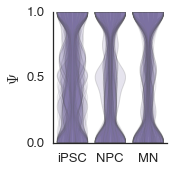

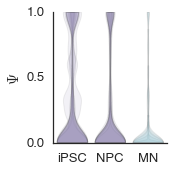

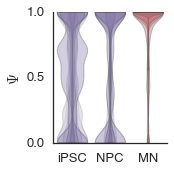

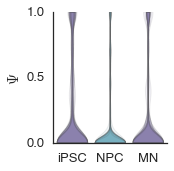

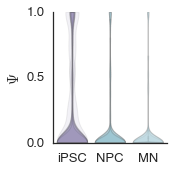

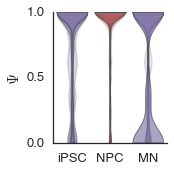

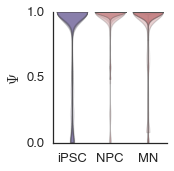

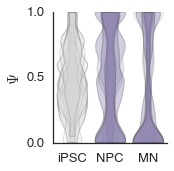

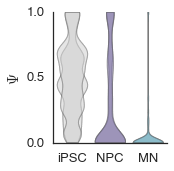

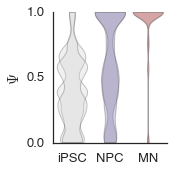

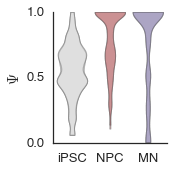

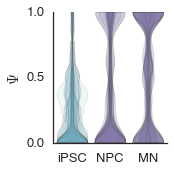

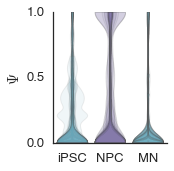

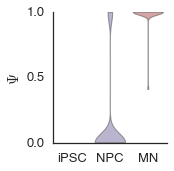

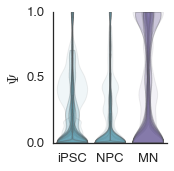

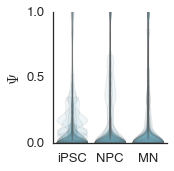

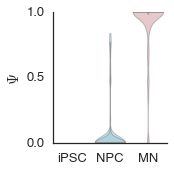

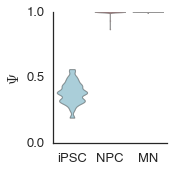

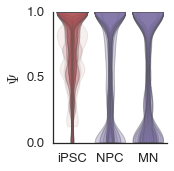

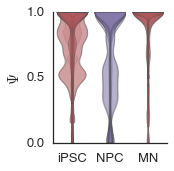

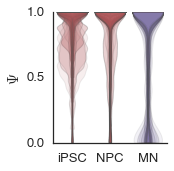

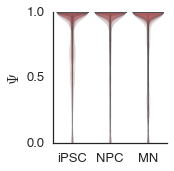

In [17]:
from modish import MODALITY_TO_COLOR
import matplotlib as mpl

for modalities, s in modality_across_celltypes.groupby(modality_across_celltypes):
    print modalities, s.shape
    
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    
    if s.shape[0] <= 100:
        events = s.index
    else:
        events = np.random.choice(s.index, size=100, replace=False)
    modalities_split = modalities.split(',')
    color = [MODALITY_TO_COLOR[x] for x in modalities_split]
    
    for event in events:
        try:
            study.splicing._violinplot(event, phenotype_groupby=study.sample_id_to_phenotype,
                                       sample_ids=singles_no_outliers_ids, stripplot=False, get_pooled=False,
                                      phenotype_order=study.phenotype_order, ax=ax, color=color,
                                      bw=0.2, ylim=(0, 1), yticks=(0, 0.5, 1), ylabel='$\Psi$')
        except ValueError:
            continue
            
    ax.set(title='', xticklabels=study.phenotype_order, xlabel='')
    sns.despine()
    alpha = max(1./(len(events)+1.), 0.1)
    
    # Add transparency
    polycollections = [x for x in ax.collections if isinstance(x, mpl.collections.PolyCollection)]
    for polycollection in polycollections:
        polycollection.set_alpha(alpha)
    fig.tight_layout()
    fig.savefig('{}/stacked_violinplots_{}.pdf'.format(folder, modalities))

## GO enrichment

In [18]:
modality_group_sizes = modality_across_celltypes.groupby(modality_across_celltypes).size()
modality_group_sizes.sort(ascending=False)
modality_group_sizes

~1,~1,~1                      6886
~0,~0,~0                      1124
~1,~1,bimodal                  286
bimodal,bimodal,bimodal        249
~1,bimodal,bimodal             122
~0,~0,bimodal                   76
~0,bimodal,~0                   73
~1,bimodal,~1                   64
bimodal,~1,bimodal              46
~0,bimodal,bimodal              38
bimodal,~1,~1                   25
bimodal,bimodal,~1              24
bimodal,~0,bimodal              23
multimodal,bimodal,bimodal      18
multimodal,bimodal,~0           14
bimodal,~0,~0                   13
bimodal,bimodal,~0              11
multimodal,~1,bimodal           10
~0,~1,~1                         4
~0,~0,~1                         2
multimodal,bimodal,~1            2
~0,bimodal,~1                    2
dtype: int64

In [19]:
study.splicing.feature_expression_id_col = 'ensembl_id'

bimodal,bimodal,bimodal (249,)
                              features_of_interest_in_go_term  \
GO:0003730    ENSG00000173933,ENSG00000205937,ENSG00000248643   
GO:0005737  ENSG00000173933,ENSG00000114956,ENSG0000019711...   
GO:0005515  ENSG00000124177,ENSG00000148484,ENSG0000012356...   
GO:0007067  ENSG00000122545,ENSG00000182628,ENSG0000016629...   
GO:0000381    ENSG00000173933,ENSG00000136527,ENSG00000248643   

                 features_of_interest_in_go_term_gene_symbols  \
GO:0003730                              RBM4,RNPS1,RBM14-RBM4   
GO:0005737  RBM4,DGUOK,PCBP2,GPBP1,DPH3,MFF,PRMT2,SAT2,USP...   
GO:0005515  CHD6,RSU1,MORF4L2,KMT2E,RBM4,PCBP2,DPH3,SEPT7,...   
GO:0007067                  SEPT7,SKA2,ANAPC16,ANAPC11,STRA13   
GO:0000381                              RBM4,TRA2B,RBM14-RBM4   

                     go_domain  \
GO:0003730  molecular_function   
GO:0005737  cellular_component   
GO:0005515  molecular_function   
GO:0007067  biological_process   
GO:0000381  biolo

/home/obotvinnik/workspace-git/flotilla/flotilla/data_model/gene_ontology.py:160: UserWarning: No GO categories enriched in provided features
  warnings.warn('No GO categories enriched in provided features')


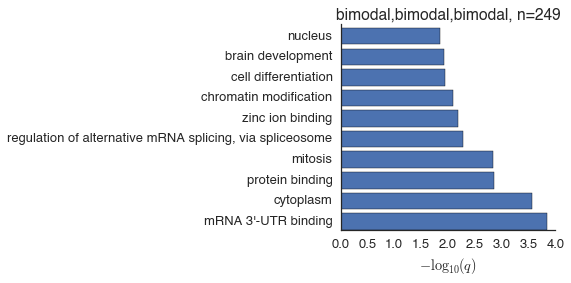

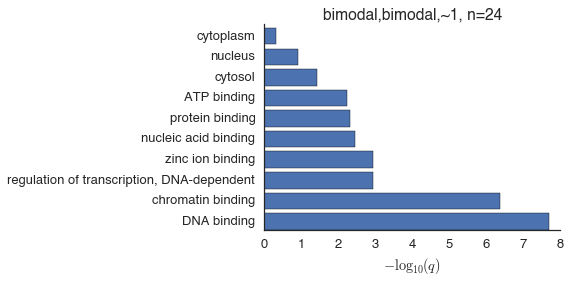

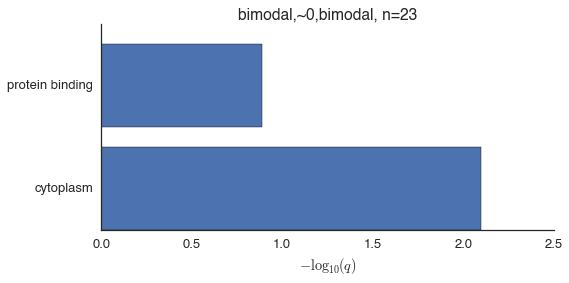

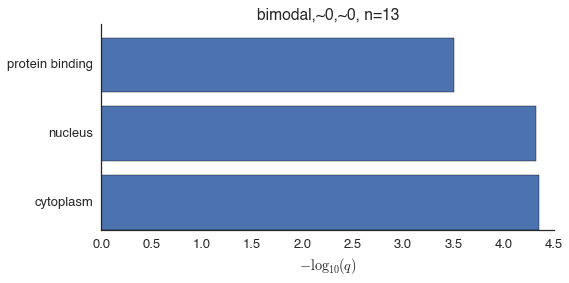

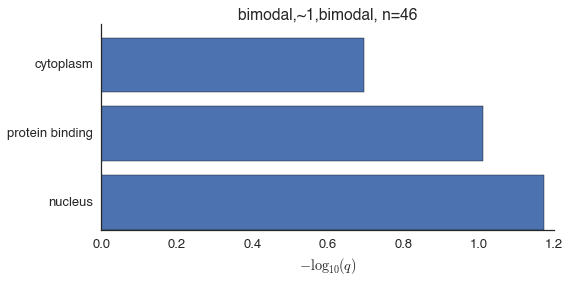

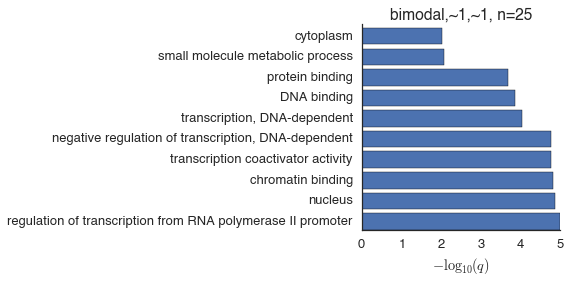

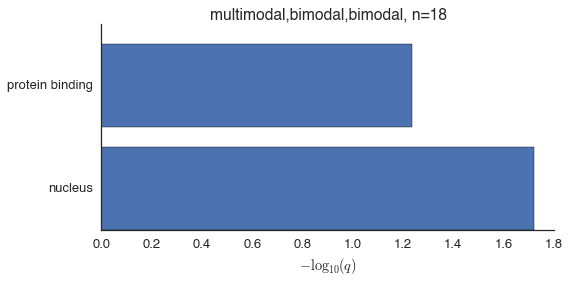

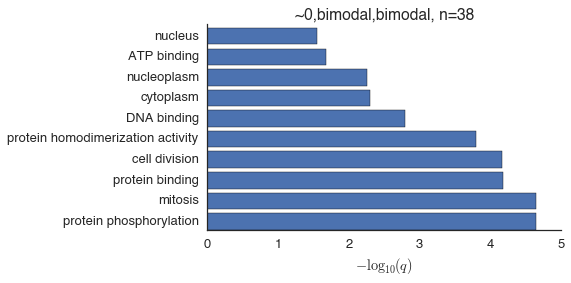

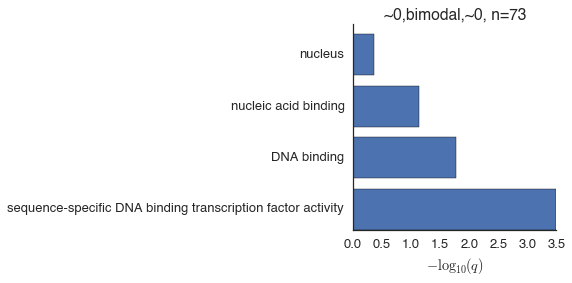

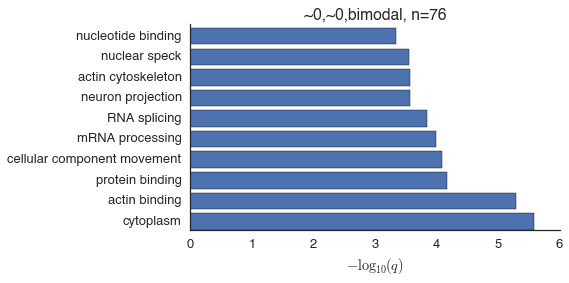

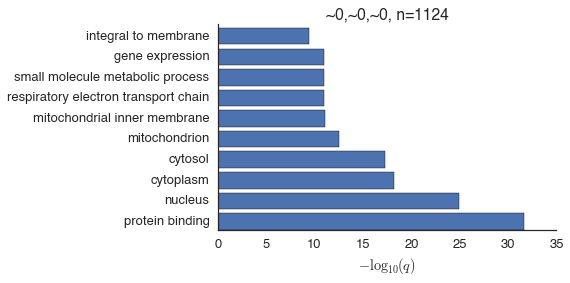

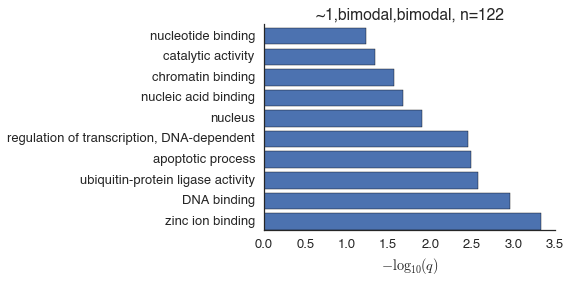

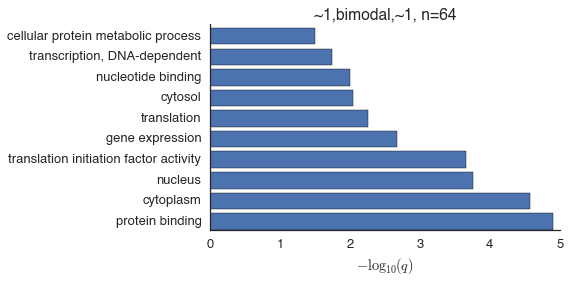

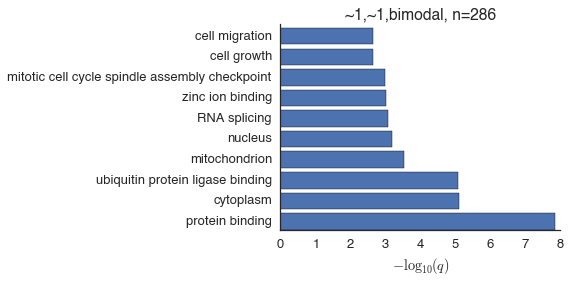

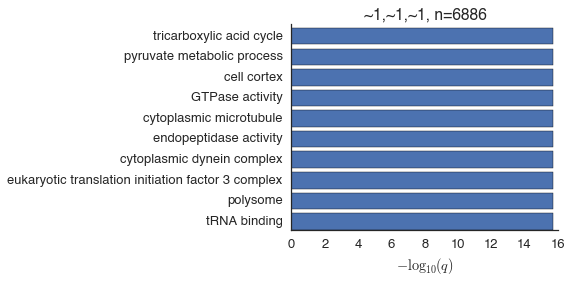

In [20]:
from flotilla.visualize.gene_ontology import plot_go_enrichment

background = study.splicing.splicing_to_expression_id(modality_across_celltypes.index)

go_dfs = []

for modalities, s in modality_across_celltypes.groupby(modality_across_celltypes):
    print modalities, s.shape
    modality_genes = study.splicing.splicing_to_expression_id(s.index)
    go = study.go_enrichment(modality_genes, background, p_value_cutoff=1)
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue
    fig, ax = plt.subplots(figsize=(8, 4))
    ax = plot_go_enrichment(data=go)
    prefix = '{}/modality_go_enrichment_across_celltypes_{}'.format(folder, modalities)
    go.to_csv('{}.csv'.format(prefix))
    go['modalities'] = modalities
    go_dfs.append(go)
    
    print go.head()
    ax.set_title('{}, n={}'.format(modalities, s.shape[0]))
    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}.pdf'.format(prefix))
go_df = pd.concat(go_dfs)

In [ ]:
g = sns.FacetGrid(go_df_subset, row='modalities', size=2, aspect=3, 
                  row_order=relevant_modality_groups.index, sharey=False)
g.map_dataframe(plot_go_enrichment, x_col=u'bonferonni_corrected_p_value', max_categories=5, color='lightgrey')
g.set(title='')
g.fig.savefig('{}/modalities_across_celltypes_go_enrichment.pdf'.format(folder))

### Enrichment of this modality vs all other modalities across phenotypes

i.e. *"What GO categories are bimodal events in iPSC, NPC and MN enriched for, over other modalities in those celltypes?"*

ambiguous
bimodal
middle
	... empty GO enrichment!
~0
~1


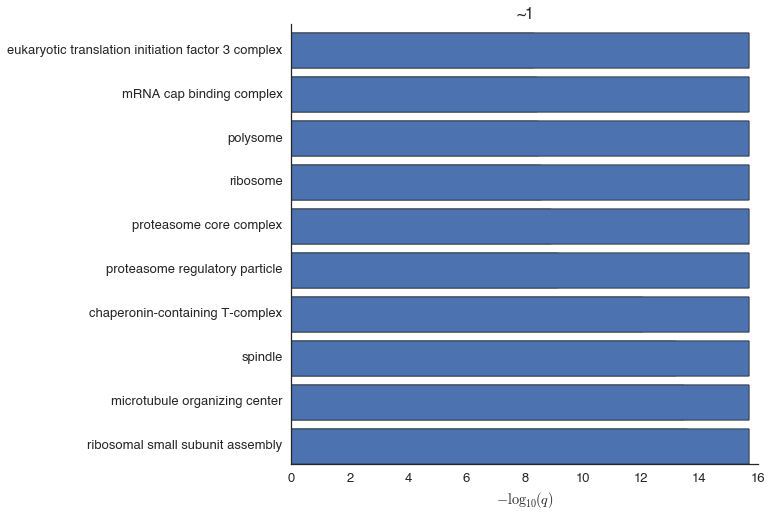

In [33]:
import itertools

background = study.splicing.splicing_to_expression_id(modalities_all_celltypes.event_name)


for (group), df1 in modalities_all_celltypes.groupby(['modality']):
    print group
    foreground = study.splicing.splicing_to_expression_id(df1.event_name)
    go = study.go_enrichment(foreground, background, p_value_cutoff=0.1)
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue

    ax = plot_go_enrichment(data=go)
    ax.set_title(group)
    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}/modality_go_enrichment_across_celltypes_{}.pdf'.format(folder, group))

### Enrichment of events which change (or don't change) modality



In [ ]:
changing_modalities = modalities_all_celltypes_no_constitutive.groupby('event_name').filter(
    lambda x: x.modality.unique().shape[0] > 1)

### Make BED files of modality trios across celltypes

In [25]:
%%time 
import pybedtools

bed_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities'
! mkdir $bed_folder

DIR = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

exon_bedfile = '{}/skipped_exon_exon2.bed'.format(DIR)
exon_bed = pybedtools.BedTool(exon_bedfile)

background_events = set(modality_across_celltypes.index)

for modality_trio, series in modality_across_celltypes.groupby(modality_across_celltypes):
    event_names = set(series.index)
    print '\n---', modality_trio, '---'
    
    format_args = bed_folder, modality_trio

    filtered_bed = exon_bed.filter(lambda x: x.name in event_names)
    filtered_filename = '{}/skipped_exon_exon2_{}.bed'.format(*format_args)
    filtered_bed.saveas(filtered_filename)

    background_bed = exon_bed.filter(lambda x: x.name not in event_names and x.name in background_events)
    background_filename = '{}/skipped_exon_exon2_{}_background.bed'.format(*format_args)
    background_bed.saveas(background_filename)

    ! wc -l $filtered_filename
    ! wc -l $background_filename

mkdir: cannot create directory `/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities': File exists

--- bimodal,bimodal,bimodal ---
249 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_bimodal,bimodal,bimodal.bed
8863 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_bimodal,bimodal,bimodal_background.bed

--- bimodal,bimodal,~0 ---
11 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_bimodal,bimodal,~0.bed
9101 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_bimodal,bimodal,~0_background.bed

--- bimodal,bimodal,~1 ---
24 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_bimodal,bimodal,~1.bed
9088 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_bimodal,bimodal,~1_background.bed

--- bimodal,~0,bimodal ---
23 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figur

In [26]:
mkdir /home/obotvinnik/projects/singlecell_pnms/analysis/homer/

mkdir: cannot create directory `/home/obotvinnik/projects/singlecell_pnms/analysis/homer/': File exists


## HOMER enrichment


In [3]:
homer_dir = '{}/homer'.format(bed_folder)
! mkdir $homer_dir

### First extract upstream/downstream intron sequences

In [28]:
%%time

import os
import glob
import pybedtools

nt = 200

directions = 'upstream', 'downstream'

for bedfile in glob.iglob('{}/skipped_exon_exon2_*.bed'.format(bed_folder)):
    basename = os.path.basename(bedfile)
    print basename
    prefix = basename.split('.bed')[0]
    bed = pybedtools.BedTool(bedfile)
    
    for direction in directions:
        # Get downstream intron
        if direction == 'downstream':
            intron = bed.flank(l=0, r=nt, s=True, g=pybedtools.chromsizes('hg19'))
        elif direction == 'upstream':
            intron = bed.flank(l=nt, r=0, s=True, g=pybedtools.chromsizes('hg19'))
    
    # Saved every exon that was exactly upstream or downstream of a junction,
    # So when taking the flanking sequence, there's a lot of repetition
    unique = pybedtools.BedTool(list(set(x for x in intron)))
    
    
    print '\t', len(intron), len(unique)
    saveas = '{}/{}_{}{}.bed'.format(bed_folder, prefix, direction, nt)
    print '\t', saveas
    unique.saveas(saveas)

skipped_exon_exon2_~0,~0,bimodal.bed
	76 76
	/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_~0,~0,bimodal_downstream200.bed
skipped_exon_exon2_~1,bimodal,bimodal.bed
	122 122
	/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_~1,bimodal,bimodal_downstream200.bed
skipped_exon_exon2_~0,bimodal,~1_background.bed
	9110 9110
	/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_~0,bimodal,~1_background_downstream200.bed
skipped_exon_exon2_multimodal,bimodal,~1_background.bed
	9110 9110
	/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_multimodal,bimodal,~1_background_downstream200.bed
skipped_exon_exon2_bimodal,bimodal,~1_background.bed
	9088 9088
	/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_bimodal,bimodal,~1_background_downstream200.bed
skipped_exon_exon2_~0,~0,~1_background.bed
	9110 9110
	/projects/ps-yeolab

### Motif Enrichment of modality trios

Using HOMER

#### Background:  all other modality trios


In [32]:
import os
from gscripts.qtools import Submitter
import glob


findMotifsGenome = '/home/yeo-lab/software/homer/bin/findMotifsGenome.pl'
n_processors = 4
homer_flags = '-rna -len 4,5,6,7 -mset vertebrates -mis 1 -p {}'.format(n_processors)

commands = []

homer_folder = '{}/homer'.format(bed_folder)
! mkdir $homer_folder

for bedfile in glob.iglob('{}/skipped_exon_exon2_*.bed'.format(bed_folder)):
    if 'background' in bedfile:
        continue
    
    basename = os.path.basename(bedfile)
    prefix = basename.split('.')[0]
    modality = prefix.split('_')[3]
    if modality.startswith('constitutively'):
        continue
    
    background = bedfile.replace(modality, modality+ '_background')
    out_dir = '{}/{}'.format(homer_folder, basename.replace('.bed', '_vs_other_modality_trios'))
    command = '{} {} hg19 {} -bg {} {}'.format(
        findMotifsGenome, bedfile, out_dir, background, homer_flags)
    print '\n', command
    commands.append(command)
#     ! $command
jobname = 'homer_vs_other_modality_trios'
sub = Submitter(commands, jobname, walltime='1:00:00', queue='home-scrm',
               ppn=n_processors, write_and_submit=True, array=True,
               out_filename='{}/{}.out'.format(homer_dir, jobname),
               err_filename='{}/{}.err'.format(homer_dir, jobname))

mkdir: cannot create directory `/projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/homer': File exists

/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_~0,~0,bimodal.bed hg19 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/homer/skipped_exon_exon2_~0,~0,bimodal_vs_other_modality_trios -bg /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_~0,~0,bimodal_background.bed -rna -len 4,5,6,7 -mset vertebrates -mis 1 -p 4

/home/yeo-lab/software/homer/bin/findMotifsGenome.pl /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_~0,~0,~1_downstream200.bed hg19 /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/homer/skipped_exon_exon2_~0,~0,~1_downstream200_vs_other_modality_trios -bg /projects/ps-yeolab/obotvinnik/singlecell_pnms/figure3_modalities/skipped_exon_exon2_~0,~0,~1_background_downstr

NameError: name 'homer_dir' is not defined

## PCA of constitutively expressed genes